In [1]:
import numpy as np
np.random.seed(42)

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import recall_score, roc_auc_score, precision_score, matthews_corrcoef, classification_report, roc_curve
%matplotlib inline

In [4]:
from utils import plot_confusion_matrix, plot_feature_importance

In [5]:
# sklearn
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler, normalize
from sklearn.compose import ColumnTransformer

In [6]:
def score_fn(gt, pred):
    return recall_score(gt, pred, average='macro', zero_division=0)

In [7]:
train_df = pd.read_csv('train_processed2.csv', low_memory=False)

In [8]:
useless_cols = [
    'mailrank',
    'postmark',
    'name_mfi',
    'city',
    'post',
    'oper_type_code',
    'oper_type_class',
    'index_oper',
    'oper_type',
    'oper_attr',
    'priority',
    
#     'class',
    'type',
]

In [9]:
str_cat_cols = [
    'type'
]

In [10]:
num_cols = [
    'weight',
    'transport_pay',
    'price_mfi',
    'dist_qty_oper_login_1',
    'total_qty_oper_login_1',
    'total_qty_oper_login_0',
    'total_qty_over_index_and_type',
    'total_qty_over_index',
]

In [11]:
bin_cols = [
    'is_privatecategory',
    'is_in_yandex',
    'is_return',
    'is_wrong_sndr_name',
    'is_wrong_rcpn_name',
    'is_wrong_phone_number',
    'is_wrong_address',
]

In [12]:
num_cat_cols = [
    'mailctg',
    'directctg',
    'class',
    'mailtype',
    'priority',
]

In [13]:
num_scale_cols = [
    'total_qty_oper_login_0', 'total_qty_oper_login_1',
    'total_qty_over_index', 'total_qty_over_index_and_type',
    'transport_pay', 'weight', 'weight_diff', 'weight_mfi',
]

In [14]:
drop_dup_subset = ['label']

In [15]:
class Dataset():
    
    def __init__(self, train_df, keep=True, val_size=0.3,
                 drop_major=False, drop_minor=False,
                 num_cat_cols=num_cat_cols,
                 num_scale_cols=num_scale_cols,
                 str_cat_cols=str_cat_cols,
                 useless_cols=useless_cols,
                 drop_dup_subset=drop_dup_subset
                ):
        self._train = train_df
        
        if val_size == 0:
            self.train = self._train
            self.val = self._train.sample(100)
        else:
            self.train, self.val = train_test_split(self._train, 
                                                    test_size=val_size,
                                                    stratify=self._train.label,
                                                    random_state=42,
                                                   )
        self.cols = self._train.columns
        self.useless_cols = [c for c in useless_cols if c in self.cols]

        self.num_cat_cols = [c for c in num_cat_cols if c in self.cols and c not in useless_cols]
        self.num_scale_cols = [c for c in num_scale_cols if c in self.cols and c not in useless_cols]
        self.str_cat_cols = [c for c in str_cat_cols if c in self.cols and c not in useless_cols]
        self.drop_dup_subset = [c for c in drop_dup_subset if c in self.cols and c not in useless_cols]
        self.cat_cols = self.num_cat_cols + self.str_cat_cols
        
        del self._train
        self.train = self.preprocess(self.train, 'train', keep=keep)
        self.val = self.preprocess(self.val, 'val')
        
                
        major = self.train[self.train.label == 0]
        if drop_major:
            major = major.drop_duplicates()
        
        minor = self.train[self.train.label == 1]
        if drop_minor:
            minor = minor.drop_duplicates()
        
        self.train = pd.concat([major, minor])
        
        self.enc = ColumnTransformer(
            [
                ('one_hot_encoder', OneHotEncoder(categories='auto', sparse=False), self.cat_cols),
                ('robust_scaler', RobustScaler(), self.num_scale_cols),
            ],
            remainder='passthrough'                                      
        )
        self.enc.fit(pd.concat([self.train, self.val]).drop(['label'], axis=1))     
        self.cat_features = []
        self.cat_features_ids = []
        for i, f in enumerate(self.enc.get_feature_names_out()):
            
            if f.startswith('one_hot') or f.startswith('remainder__is') or f.split('_')[-1] in self.cat_cols:
                self.cat_features.append(f)
                self.cat_features_ids.append(i)
        
        
    def preprocess(self, df, part='train', keep=None):    
        is_train = part == 'train'

        
        df = df.drop(self.useless_cols, axis=1)
        df = df.fillna(0)
        
        df['oper_log_1_over_dist'] = df['total_qty_oper_login_1'] / (df['dist_qty_oper_login_1'] + 1)
        df['oper_log_0_over_dist'] = df['total_qty_oper_login_0'] / (df['dist_qty_oper_login_1'] + 1)
        df['total_over_dist'] = df['total_qty_oper_login_0'] / (df['dist_qty_oper_login_1'] + 1)

        # num cat cols
        for c in self.num_cat_cols:
            df[c] = df[c].apply(lambda x: int(float(x))).astype(int).astype('category')
            
        #str cat cols
        df[self.str_cat_cols] = df[self.str_cat_cols].astype(str).astype('category')
        

                
        if is_train and keep != True:
            df = df.sort_values(by=['label']).drop_duplicates(
                subset=[c for c in df.columns if c not in self.drop_dup_subset],
                keep=keep,
            )
        return df
    
    def get_train(self, mode=None):
        df = self.train
        X = self.enc.transform(df.drop(['label'], axis=1))        
        y = df.label
        return X, y
    
    def get_val(self):
        df = self.val
        X = self.enc.transform(df.drop(['label'],1))
        y = df.label
        return X, y
    
    def get_test(self, file):
        test = pd.read_csv(file, low_memory=False)
        t = self.preprocess(test, 'test')
        return self.enc.transform(t)

In [63]:
ds = Dataset(
    train_df,
    drop_major=True, drop_minor=True,
    val_size=0.2,
    keep='last',
)

In [17]:
_X_train, _y_train = ds.get_train(mode=None)

In [18]:
X_val, y_val = ds.get_val()

In [19]:
X_train, y_train = _X_train, _y_train

In [20]:
pd.Series(y_train).value_counts(1)

0    0.910267
1    0.089733
Name: label, dtype: float64

In [21]:
def get_best_thresh(proba, y_true, start=0, end=0.9, step=0.001):
    res = dict()
    for t in np.arange(start, end, step):
        pred = np.where(np.array(proba) > t, 1, 0)
        res[t] = score_fn(y_true, pred)
    return sorted(res.items(), key=lambda x: x[1], reverse=1)

In [22]:
def thresh_by_roc(proba, y_val):
    fpr, tpr, thresholds = roc_curve(y_val, proba, drop_intermediate=False)
    return thresholds[np.argmin(np.abs(fpr+tpr-1))]

In [23]:
def pipeline(model_class, params, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val):
    model = model_class(**params)
    model = model.fit(X_train, y_train)
    val_proba = model.predict_proba(X_val)[:, 1]
    r = np.array(get_best_thresh(val_proba, y_val, start=0, end=0.6)[:3])
    threshes = r[:, 0]
    scores = r[:, 1]
    thresh = np.mean(threshes)
    print(f'thresholds: {threshes}')
    print(f'mean: {thresh}')
    val_pred = np.where(val_proba > thresh, 1, 0)
    print(pd.Series(val_pred).value_counts(normalize=1))
    plot_confusion_matrix(y_val, val_pred, normalize=0)
    return model, thresh, np.mean(scores)

In [24]:
from sklearn.metrics import roc_auc_score, precision_recall_curve
def plot_roc_curve(y_val, val_probs):
    fpr, tpr, thresholds = roc_curve(y_val, val_probs)
    plt.figure(figsize=(10, 10))
    plt.plot([0,1], [0,1], linestyle='--', label='')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

## Random Forest

thresholds: [0.044 0.045 0.046]
mean: 0.045000000000000005
0    0.810649
1    0.189351
dtype: float64


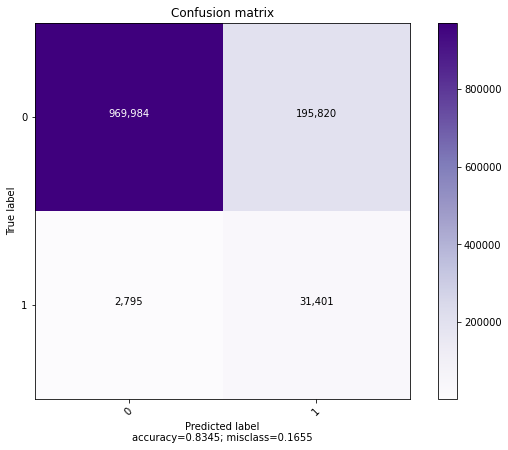

              precision    recall  f1-score   support

           0       1.00      0.83      0.91   1165804
           1       0.14      0.92      0.24     34196

    accuracy                           0.83   1200000
   macro avg       0.57      0.88      0.57   1200000
weighted avg       0.97      0.83      0.89   1200000

target: 0.8751476890728397


In [25]:
rf_pipe = pipeline(
    RandomForestClassifier,
    {'n_jobs': -1, 'n_estimators': 100},
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
)

In [26]:
rf = rf_pipe[0]

In [27]:
val_probs = rf.predict_proba(X_val)[:, 1]

Best Threshold=0.050000, G-Mean=0.874


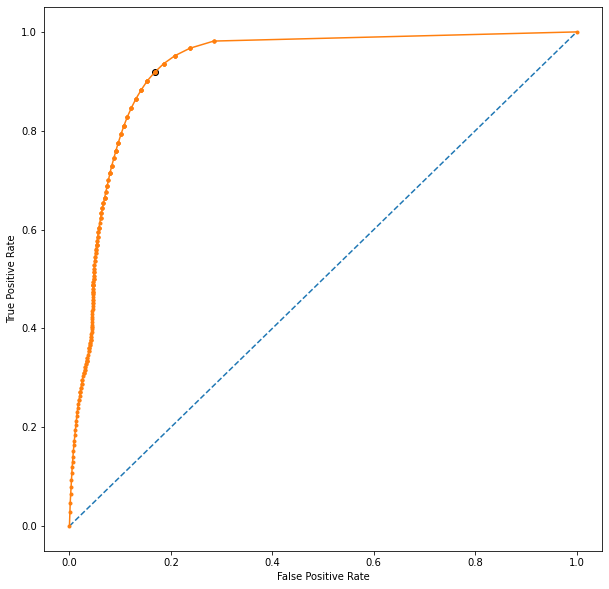

In [28]:
plot_roc_curve(y_val, val_probs)

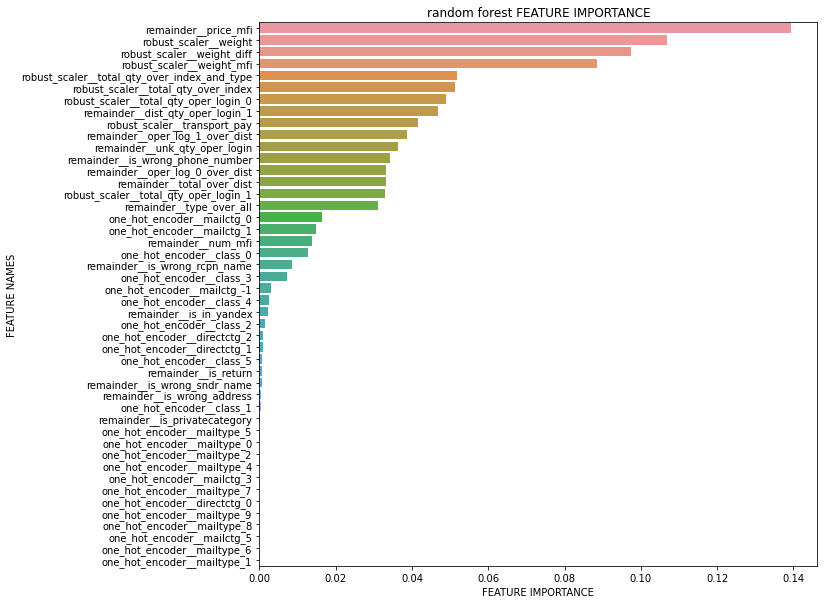

In [65]:
plot_feature_importance(rf.feature_importances_, ds.enc.get_feature_names_out(), 'random forest ')

thresholds: [0.03  0.031 0.032]
mean: 0.031
0    0.81764
1    0.18236
dtype: float64


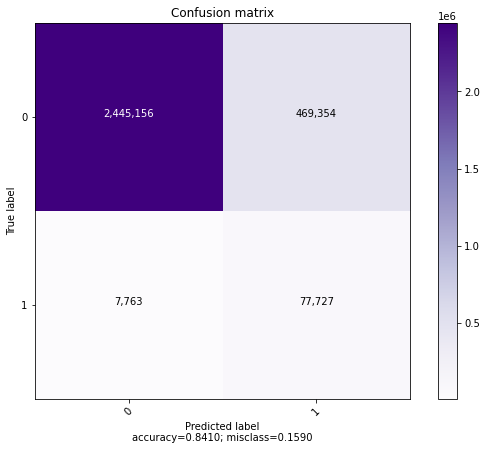

              precision    recall  f1-score   support

           0       1.00      0.84      0.91   2914510
           1       0.14      0.91      0.25     85490

    accuracy                           0.84   3000000
   macro avg       0.57      0.87      0.58   3000000
weighted avg       0.97      0.84      0.89   3000000

target: 0.8740768042232843


In [24]:
ds1 = Dataset(
    train_df,
    drop_major=True, drop_minor=False,
    val_size=0.5,
    keep='last',
)
X_train1, y_train1 = ds1.get_train(mode=None)
X_val1, y_val1 = ds1.get_val()
rf_pipe1 = pipeline(
    RandomForestClassifier,
    {'n_jobs': -1, 'n_estimators': 100},
    X_train=X_train1,
    y_train=y_train1,
    X_val=X_val1,
    y_val=y_val1,
)

thresholds: [0.03  0.031 0.032]
mean: 0.031
0    0.799363
1    0.200637
dtype: float64


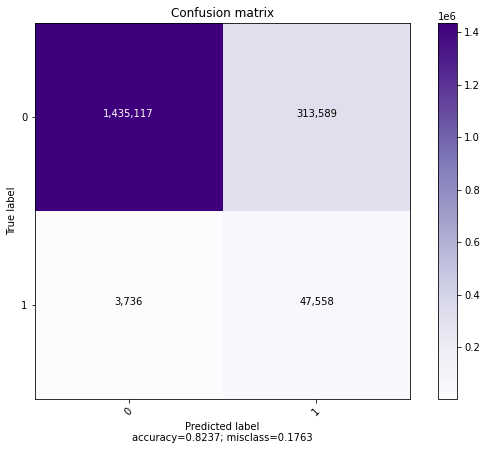

              precision    recall  f1-score   support

           0       1.00      0.82      0.90   1748706
           1       0.13      0.93      0.23     51294

    accuracy                           0.82   1800000
   macro avg       0.56      0.87      0.57   1800000
weighted avg       0.97      0.82      0.88   1800000

target: 0.8739193286382464


In [25]:
ds2 = Dataset(
    train_df,
    drop_major=True, drop_minor=False,
    val_size=0.3,
    keep='last',
)
X_train2, y_train2 = ds2.get_train(mode=None)
X_val2, y_val2 = ds2.get_val()
rf_pipe2 = pipeline(
    RandomForestClassifier,
    {'n_jobs': -1, 'n_estimators': 100},
    X_train=X_train2,
    y_train=y_train2,
    X_val=X_val2,
    y_val=y_val2,
)

thresholds: [0.04  0.041 0.042]
mean: 0.041
0    0.80151
1    0.19849
dtype: float64


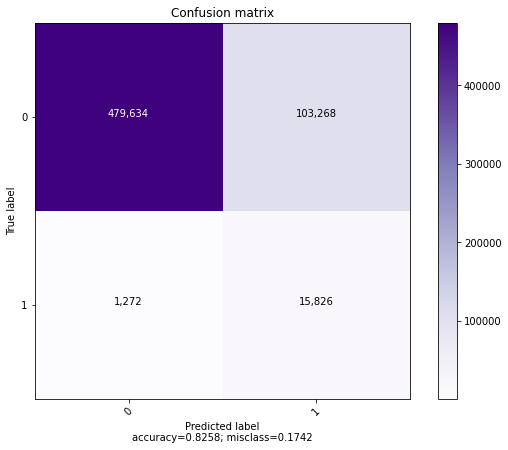

              precision    recall  f1-score   support

           0       1.00      0.82      0.90    582902
           1       0.13      0.93      0.23     17098

    accuracy                           0.83    600000
   macro avg       0.57      0.87      0.57    600000
weighted avg       0.97      0.83      0.88    600000

target: 0.8742217391382368


In [26]:
ds3 = Dataset(
    train_df,
    drop_major=True, drop_minor=False,
    val_size=0.1,
    keep='last',
)
X_train3, y_train3 = ds3.get_train(mode=None)
X_val3, y_val3 = ds3.get_val()
rf_pipe3 = pipeline(
    RandomForestClassifier,
    {'n_jobs': -1, 'n_estimators': 100},
    X_train=X_train3,
    y_train=y_train3,
    X_val=X_val3,
    y_val=y_val3,
)

thresholds: [0.03030303 0.03333333 0.03636364]
mean: 0.03333333333333333
0    0.799849
1    0.200151
dtype: float64


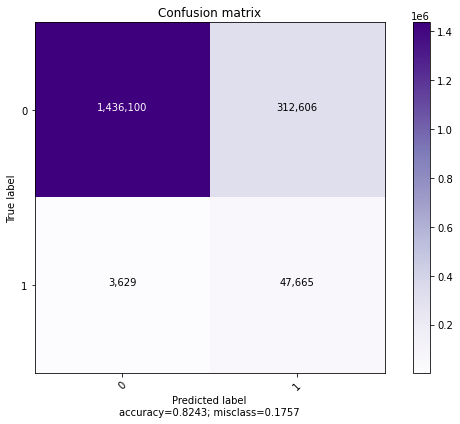

              precision    recall  f1-score   support

           0       1.00      0.82      0.90   1748706
           1       0.13      0.93      0.23     51294

    accuracy                           0.82   1800000
   macro avg       0.56      0.88      0.57   1800000
weighted avg       0.97      0.82      0.88   1800000

target: 0.8752434005879469


In [157]:
#повторого проведем второй эксперимент
rf_pipe2_2 = pipeline(
    RandomForestClassifier,
    {'n_jobs': -1, 'n_estimators': 100},
    X_train=X_train2,
    y_train=y_train2,
    X_val=X_val2,
    y_val=y_val2,
)

In [28]:
rf1 = rf_pipe1[0]

In [29]:
val_proba1 = rf1.predict_proba(X_val1)[:, 1]

In [30]:
np.mean(val_proba1)

0.05511434999999996

In [31]:
rf2 = rf_pipe2[0]

In [32]:
val_proba2 = rf2.predict_proba(X_val2)[:, 1]

In [33]:
np.mean(val_proba2)

0.06263750555555556

In [34]:
rf3 = rf_pipe3[0]

In [35]:
val_proba3 = rf3.predict_proba(X_val3)[:, 1]

In [36]:
np.mean(val_proba3)

0.07000768333333335

Best Threshold=0.040000, G-Mean=0.873


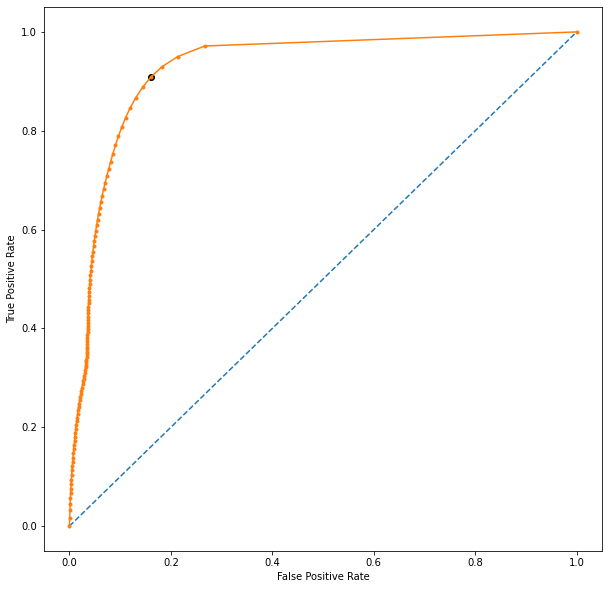

In [37]:
plot_roc_curve(y_val1, val_proba1)

Best Threshold=0.050000, G-Mean=0.873


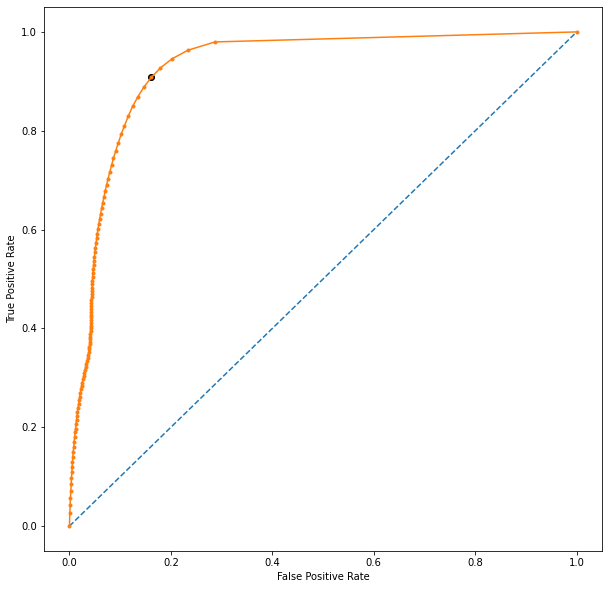

In [38]:
plot_roc_curve(y_val2, val_proba2)

Best Threshold=0.050000, G-Mean=0.873


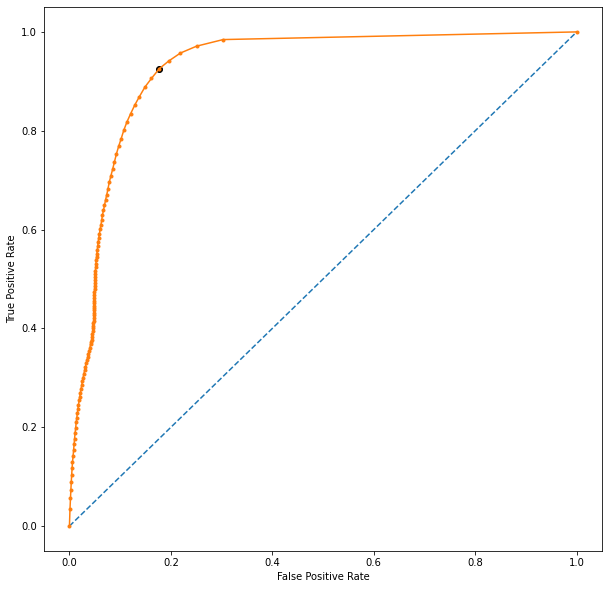

In [39]:
plot_roc_curve(y_val3, val_proba3)

### Тенденция четко прослеживается, следующий порог должен быть больше

### комбинирование двух моделей дало ощутимый прирост!

In [29]:
class AggModel():
    def __init__(
        self,
        base_model_cls,
        model_params,
        n_models=3,
    ):
        self.n_models = n_models
        self.models = [
            base_model_cls(**model_params) for _ in range(n_models)
        ]
        
    def fit(self, X, y):
        for i in range(self.n_models):
            self.models[i].fit(X, y)
            print(f'done {i+1}/{self.n_models}')
        return self
    
    def predict_proba(self, X):
        probs = []
        for model in self.models:
            proba = model.predict_proba(X)
            probs.append(proba)
        return np.average(np.array(probs), axis=0)

done 1/3
done 2/3
done 3/3
thresholds: [0.045 0.043 0.044]
mean: 0.044000000000000004
0    0.808188
1    0.191812
dtype: float64


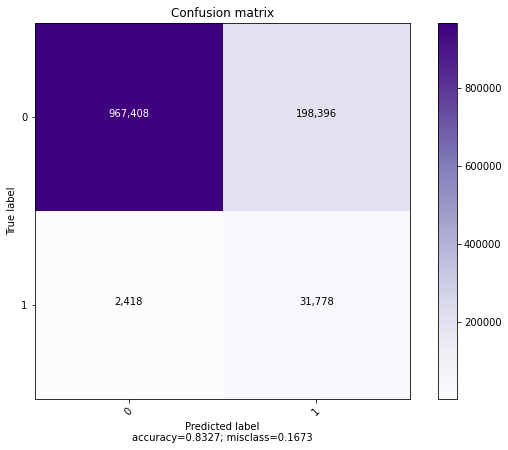

              precision    recall  f1-score   support

           0       1.00      0.83      0.91   1165804
           1       0.14      0.93      0.24     34196

    accuracy                           0.83   1200000
   macro avg       0.57      0.88      0.57   1200000
weighted avg       0.97      0.83      0.89   1200000

target: 0.8795552127642676


In [30]:
agg_pipe = pipeline(
    AggModel,
    {
        'base_model_cls': RandomForestClassifier,
        'model_params': {'n_jobs': -1, 'n_estimators': 300},
        'n_models': 3,
    },
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
)

In [33]:
agg_val_proba = agg_pipe[0].predict_proba(X_val)[:, 1]

Best Threshold=0.044546, G-Mean=0.878


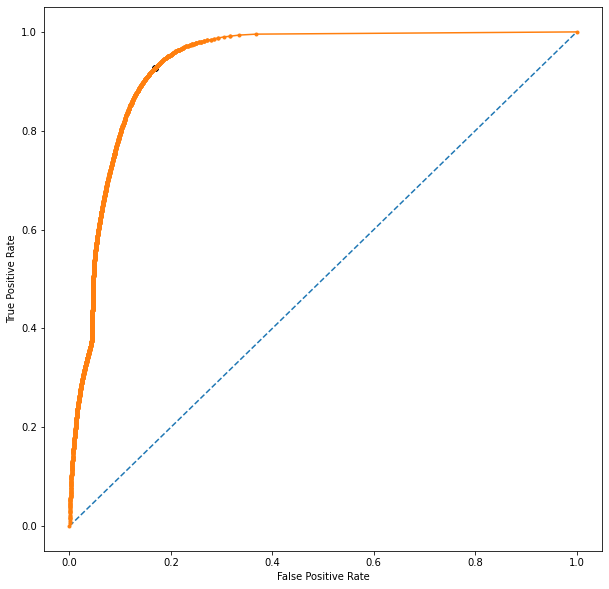

In [34]:
plot_roc_curve(y_val, agg_val_proba)

In [35]:
thresh_by_roc(agg_val_proba, y_val)

0.07565741857659831

In [102]:
np.round(0.007 * (0.0442 / 0.0333)  ,  3)

0.009

In [86]:
#все числа получены из валидации
t = np.round(0.007 * (0.0442 / 0.0333)  ,  3)

In [87]:
t

0.009

In [52]:
del ds, X_train, y_train, X_val

In [54]:
del agg_pipe

In [37]:
ds = Dataset(
    train_df,
    drop_major=True, drop_minor=True,
    val_size=0,
    keep='last',
)
X, y = ds.get_train(mode=None)

In [38]:
model = AggModel(
    **{
        'base_model_cls': RandomForestClassifier,
        'model_params': {'n_jobs': -1, 'n_estimators': 300},
        'n_models': 3,
    },
)

In [39]:
model.fit(X, y)

done 1/3
done 2/3
done 3/3


In [40]:
X_test = ds.get_test('test_processed2.csv')

In [41]:
test_probs = model.predict_proba(X_test)[:, 1]

In [100]:
test_pred = np.where(test_probs > t, 1, 0)

In [60]:
# del ds, X_test

In [73]:
solution = pd.read_csv('solution_base.csv')
solution['label'] = test_pred
solution.to_csv('final_solution+cls+robust+new_features_t_009.csv', index=False)